# Problema de los dos cuerpos,  Con masa variable.
## Computación cientifica I , Proyecto Final
Nataly Phawllyn Neira Parra Cod: 614212782

In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
import seaborn as sns
import math

#Métodos usados

##Euler forward

In [2]:
def euler_sistemas(m,t0,y0,f,h,N):
  """
  ENTRADAS
      m : cantidad de variables
      t0: tiempo inicial
      y0: valor inicial de las m variables
      f : función de tasa de cambio - entrega vector de longitud m , por defecto
      h : longitud de paso
      N : cantidad de pasos
   SALIDAS
      th: lista de tiempos para la solución discreta
      yh: solución discreta en todos los pasos de tiempo - para las m variables

  """

  th = np.zeros(N+1)
  yh = np.zeros((m,N+1))


  th[0] = t0
  yh[:,0] = y0[:]

  for n in range(N):
    th[n+1] = t0 + (n+1)*h
    yh[:,n+1] = yh[:,n] + h * f(th[n], yh[:,n])  # calculamos las  velocidades dependiendo de las aceleraciones

  return th,yh

## Punto Medio explicito

In [3]:
def punto_medio_explicito(m, t0, y0, f, h, N):
    """
      ENTRADAS
        m : cantidad de variables
        t0: tiempo inicial
        y0: valor inicial de las m variables
        f : función de tasa de cambio - entrega vector de longitud m
        h : longitud de paso
        N : cantidad de pasos

      SALIDAS
        t: lista de tiempos para la solución discreta
        yh: solución discreta en todos los pasos de tiempo - para las m variables
      """
    th = np.zeros(N+1)
    yh = np.zeros((m,N+1))


    th[0] = t0
    yh[:,0] = y0[:]


    k1=np.zeros((m,))
    k2=np.zeros((m,))

    for n in range(N):
        th[n+1] = t0 + (n+1)*h
        k1[:] = f(th[n],yh[:,n])
        k2[:] = f((th[n] + th[n+1])/ 2, yh[:,n] + (0.5 * h * k1[:]))
        yh[:,n+1] = yh[:,n] +  h* k2[:]

    return th, yh



## Newton Raphson  
>Esta función se usa solo como parte del cálculo de los métodos  Euler y trapecio Implicitos

In [4]:
def newton_raphson_sistemas(m,expresion,jacobiano,imax,precision,x_0):
  """
      Esta función  implementa  Método de Newton-Raphson para encontrar una solución aproximada para
      expresion(x)==0
      ENTRADAS:
        m[int]     :   número de variables del  sistema.
        expresion  :   un objeto que pueda ser usado como función de un número real x
        jacobiano  :   un objeto como el anterior, y que evalúe derivadas de 'expresion'
        imax       :   número máximo de iteraciones
        precision  :   la precisión absoluta para la convergencia según las variaciones
        x_0        :   aproximación inicial para la solución
      SALIDAS:
        EXITO     :  bandera para corroborar que solución se halló sin complicaciones
        x_nueva   :   solución final, que cumple precisión exigida si 'EXITO' es True
  """
  EXITO = False
  x_vieja = np.copy(x_0)
  for i in range(imax):
     x_nueva = x_vieja - np.linalg.solve(jacobiano(x_vieja),expresion(x_vieja) )
     if np.linalg.norm(x_nueva-x_vieja) <= precision :
       EXITO = True
       break
     else:
       x_vieja = np.copy(x_nueva)

  return x_nueva, EXITO

## Euler Backward

In [5]:
def backward_euler_sistemas(m,t0,y0,f,df,h,N):
  """
   Método de Backward Euler para integrar PVI - sistemas
   ENTRADAS
      m : cantidad de variables
      t0: tiempo inicial
      y0: valor inicial de las m variables
      f : función de tasa de cambio - entrega vector de longitud m
      df: jacobiano de f - entrega matriz m x m, donde   [df]_ij = df_i / dy_j
      h : longitud de paso
      N : cantidad de pasos
   SALIDAS
      th: lista de tiempos para la solución discreta
      yh: solución discreta en todos los pasos de tiempo - para las m variables
 """

  th = np.zeros(N+1)
  yh = np.zeros((m,N+1))

  th[0] = t0
  yh[:,0] = y0[:]
  # parámetros para convergencia de método Newton-Raphson
  imax=10;precision=1e-12
  for n in range(N):
    th[n+1] = t0 + (n+1)*h
    # declaramos los objetos tipo función que se requieren dentro de Newton-Raphson
    expresion = lambda y : y - ( yh[:,n] + h * f(th[n+1], y ) )
    jacobiano = lambda y : np.identity(m) - h * df(th[n+1], y )
    y_nuevo,EXITO = newton_raphson_sistemas(m,expresion,jacobiano,imax,precision,yh[:,n])
    if EXITO==True:
      yh[:,n+1] = y_nuevo
    else:
      print('Error al calcular solución para el paso ',n+1)
      break

  return th,yh

## Trapecio Implicito

In [6]:
def trapecio_impl_sistema(m,t0,y0,f,df,h,N):
  """
  ENTRADAS
    t0: tiempo inicial
    y0: valor inicial
    f : función de tasa de cambio
    df: derivada parcial de f conrespecto a y
    h : longitud de paso
    N : cantidad de pasos
  SALIDAS
    th: lista de tiempos para la solución discreta
    yh: solución discreta en todos los pasos de tiempo
  """
  th = np.zeros(N+1)
  yh = np.zeros((m,N+1))

  th[0] = t0
  yh[:,0] = y0[:]
  # parámetros para convergencia de método Newton-Raphson
  imax=10; precision=1e-12
  for n in range(N):
    th[n+1] = t0 + (n+1)*h
    # declaramos los objetos tipo función que se requieren dentro de Newton-Raphson
    expresion = lambda y : y - (yh[:,n] + 0.5 * h * (f(th[n], yh[:,n]) + f(th[n+1], y )))
    jacobiano = lambda y : np.identity(m) - 0.5 * h * df(th[n+1], y )
    y_nuevo,EXITO = newton_raphson_sistemas(m,expresion,jacobiano,imax,precision,yh[:,n])
    if EXITO==True:
      yh[:,n+1] = y_nuevo
    else:
      print('Error al calcular solución para el paso ',n+1)
      break
  return th,yh

#Planteamiento del sistema  de Ecuaciones

## Problema de 1 cuerpo

 Un cuerpo de masa $m_1$  bajo la acción gravitatoria de un  cuerpo de masa $M$,  con $M>>m$

 $$a=-\frac{GM}{|r|^2}\hat{r}$$
con $r$ el vector posición $r=x\hat{i}+y\hat{j}$
asi  la aceleración por componentes es

$$a=\left\{\begin{array}{c}
\ddot{x}=-\frac{GM}{(x^2+y^2)^\frac{3}{2}}x\hat{i}\\
\ddot{y}=-\frac{GM}{(x^2+y^2)^\frac{3}{2}}y\hat{j}
\end{array} \right.$$

Pero los  metodos  conocidos  para implementar en este proyecto  son  para  EDO's  de primer  orden  asi  que  reescribiremos el sistema, sabiendo que la  velocidad $V$ es la primera derivada de la posición, por lo tanto  el sistema  queda  de la  siguiente manera

$$\left\{\begin{array}{c}
\dot{x}=V_x\\
\dot{y}=V_y\\
\dot{V}_x=-\frac{GM}{(x^2+y^2)^\frac{3}{2}}x\\
\dot{V}_y=-\frac{GM}{(x^2+y^2)^\frac{3}{2}}y
\end{array} \right.$$

In [ ]:
G=6.67430E-11 # m^3, Kg^-1,s^-2  cte gravitacional
#M=5.9722E24   #kg  masa de la tierra
M=1.99E30      #kg  Masa del sol


C=G*M

print("Los valores a las  constantes  son  G={} m^3/ kg s^2, Masa Sol ={} kg".format(G,M))


def sistema_problema_1cuerpo(t,r):
  """
  Esta  función calcula los  valores de la  aceleración  en cada componente,
   representa el sistema de EDO's dado para el problema de  un  cuerpo.
  ENTRADAS
    r[array] : el array de valores que representan las coordenadas x, y, vx,vy en un tiempo t
  SALIDAS
    a[array] : array  de valores  que representan la aceleración y velocidades  en el plano en un tiempo t
  """
  x,y,vx,vy=r
  norm_r=np.sqrt((x**2)+(y**2))

  dx=vx
  dy=vy
  dVx=-(C*x)/(norm_r**3)
  dVy=-(C*y)/(norm_r**3)

  return np.array([dx,dy,dVx,dVy])

def jacobiano_sistema_1cuerpo(t,r):
  """
  Esta  función calcula el jacobiano del sistema de ecuaciones dado para el problema de  un  cuerpo.
  ENTRADAS
    r[array] : array  de valores que representan las coordenadas x,y,vx,vy en un tiempo t
  SALIDAS
    J[array] : Matriz de valores  que representan el jacobiano del sistema de EDO's
  """
  x,y,vx,vy=r
  norm_r2=(x**2)+(y**2)

  dfxx=0
  dfxy=0
  dfxvx=1
  dfxvy=0

  dfyx=0
  dfyy=0
  dfyvx=0
  dfyvy=1

  dfvxx=-C*(norm_r2**(3/2)-((x**2)*3*np.sqrt(norm_r2)))/(norm_r2**3)
  dfvxy=C*x*3*y*(norm_r2**(-5/2))
  dfvxvx=0
  dfvxvy=0

  dfvyx=C*y*3*x*(norm_r2**(-5/2))
  dfvyy=-C*(norm_r2**(3/2)-((y**2)*3*np.sqrt(norm_r2)))/(norm_r2**3)
  dfvyvx=0
  dfvyvy=0



  return np.array([[dfxx, dfxy,dfxvx,dfxvy],[dfyx, dfyy,dfyvx,dfyvy],[dfvxx,dfvxy,dfvxvx,dfvxvy],[dfvyx,dfvyy,dfvyvx,dfvyvy]])

Los valores a las  constantes  son  G=6.6743e-11 m^3/ kg s^2, Masa Sol =1.99e+30 kg


###Cálculo de las  soluciones por medio de métodos numéricos

Para  probar la efectividad de los métodos  haremos la  prueba  con el sistema  Tierra-Sol, usando los  valores dados  por la  Nasa[2][3]  para :

*   Masa del  sol $M=1.99\times 10 ^{30}$ $kg$
*   Constante gravitacional $G=6.67\times 10^{-11}$ $\frac{m^3}{kg\text{ }s^2}$
    [1]
*   Distancia Tierra-sol semieje mayor  $r=149.598\times 10^{9}$ $m$

la  velocidad (tangencial) inicial  será  calculada  con la  formula
 $$v_0=\sqrt{\frac{GM}{r}}$$

 asi  nuestro PVI  tiene las  siguientes  condiciones iniciales


*   $x(0)= 149.598\times 10^{6}$ $m$
*   $y(0)=0$
*   $v_{x}(0)=0$
*   $v_{y}(0)=29796.59$ $m/s$




Calculo del periodo orbital [4]

$$T^2=\left(\frac{4\pi^2}{GM}\right)r^3$$

Este  sera el valor  tomado como tiempo  final

 con un valor de:
 * $t_0=0$ $s$
 *  $t_{final}=3.167\times 10^{7}$ $s$

 Condiciones iniciales 
 x0=149598000000.0 m, y0=0.0, Vx0=0.0, Vy0=29796.59 m/s

 El tamaño del paso  es h=630912.5190692474  con N=50 número de iteraciones 

Error al calcular solución para el paso  16


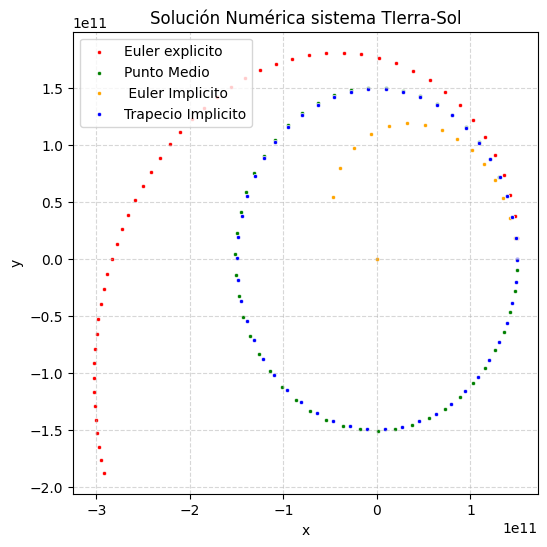

In [ ]:
#condiciones iniciales PVI
t0 = 0
r=149.598E9  #m   distancia  Sol-TIerra
y0 = np.array([r,0,0,np.sqrt(C/r)])  #[x0,y0,vx0,vy0]


#Condiciones de parada
t_final=np.sqrt(4*r/C)*(np.pi*r)
N = int(50)     #Número de iteraciones

print(" Condiciones iniciales \n x0={} m, y0={}, Vx0={}, Vy0={:.2f} m/s".format(y0[0],y0[1],y0[2],y0[3]))

#parametros de implementación numérica
m = 4                 #número de variables
h = (t_final-t0)/N     # tamaño del paso
f=sistema_problema_1cuerpo
df=jacobiano_sistema_1cuerpo

print("\n El tamaño del paso  es h={}  con N={} número de iteraciones \n".format(h,N))

#aproximación de la solución
tm, r_euler = euler_sistemas(m,t0,y0,f,h,N)
tm, r_pmedio = punto_medio_explicito(m, t0, y0, f, h, N)
tm, r_eulerimp = backward_euler_sistemas(m,t0,y0,f,df,h,N)
tm, r_trape = trapecio_impl_sistema(m,t0,y0,f,df,h,N)

#Grafica de los resultados  en 2D
plt.figure(figsize=(6, 6))
sns.scatterplot(x=r_euler[0,:], y=r_euler[1,:], label='Euler explicito', color='red', marker ='.')
sns.scatterplot(x=r_pmedio[0,:], y=r_pmedio[1,:], label='Punto Medio', color='green', marker ='.')
sns.scatterplot(x=r_eulerimp[0,:], y=r_eulerimp[1,:], label=' Euler Implicito', color='orange', marker ='.')
sns.scatterplot(x=r_trape[0,:], y=r_trape[1,:], label='Trapecio Implicito', color='blue', marker ='.')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solución Numérica sistema TIerra-Sol')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



### Analisis de error

In [ ]:
def Error_metodo(r_metodo,r_real,N,m):
  """
  esta  funcion calcula el  error  de  un  metodo usado  vs el valor  real  punto a punto
  ENTRADAS
    r_metodo[array] : los  valores aproximados de todas la  variables  en distintos t
    r_real[array]   : los  valores  reales de la función  en distintos  t
    N[int]          : número de puntos  evaluados
    m[int]          : número de variables del  sistema
  SALIDA
    error[float]   : valores del  error promedio  el error punto a punto
  """
  error=np.zeros(N+1)
  error[:]=np.linalg.norm(r_real[:2,:] - r_metodo[:2,:])/np.linalg.norm(r_real[:2,:])  #  agrege las  correcciones  hechas  en la  expo
  return np.max(error)


def error_vs_h(m,t0,y0,t_final,f,df):
  """
   esta  función calcula  el error de los metodos  para distintos  anchos de paso
   ENTRADA:
   parametros  para   usar los  distintos métodos
    m  :  numero de variables
    t0 :  condicion de tiempo inicial
    y0 :  array con condicion  inicial de las  m  variables
    t_final : valor  del tiempo  final
    f  :   sistema  de ecuaciones  direfenciales
    df  :  Jacobiano del sistema de ecuaciones
   SALIDA:[ARRAY]
    error_vs_h_euler   : errores asociados al método  euler   explicito
    error_vs_h_Pmedio  : errores asociados al método  punto medio
    error_vs_h_Euimplicito: errores asociados al método  euler  implicito
    paso   :  array  con los  h,  anchos de  paso usados

  """
  Num=np.array([10,100,1E3,1E4,1E5]).astype(int) #arreglo de pasos
  paso=[]
  error_vs_h_euler=[]
  error_vs_h_Pmedio=[]
  error_vs_h_Euimplicito=[]

  for  N in Num:
    h= (t_final-t0)/N     # tamaño del paso
    paso.append(h)
    #aproximación de la solución
    tm, r_euler = euler_sistemas(m,t0,y0,f,h,N)
    tm, r_pmedio = punto_medio_explicito(m, t0, y0, f, h, N)
    tm, r_eulerimp = backward_euler_sistemas(m,t0,y0,f,df, h,N)
    tm, r_trape = trapecio_impl_sistema(m,t0,y0,f,df, h,N)
    #calculo del error por cada h
    r_real=r_trape
    error_vs_h_euler.append(Error_metodo(r_euler,r_real,N,m))
    error_vs_h_Pmedio.append(Error_metodo(r_pmedio,r_real,N,m))
    error_vs_h_Euimplicito.append(Error_metodo(r_eulerimp,r_real,N,m))

  return error_vs_h_euler, error_vs_h_Pmedio, error_vs_h_Euimplicito,paso


Error al calcular solución para el paso  1
Error al calcular solución para el paso  7
Error al calcular solución para el paso  9


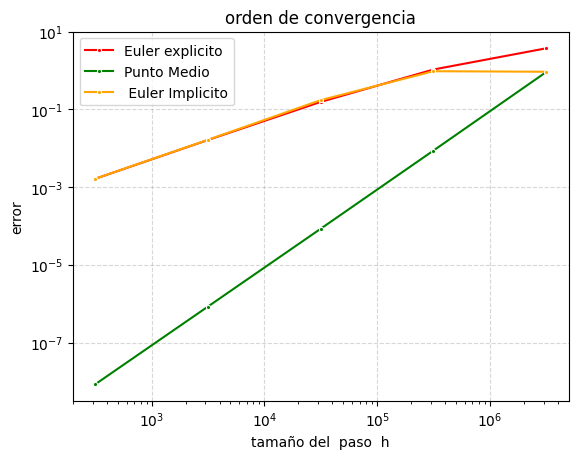

In [ ]:
error_euler,error_Pmedio,error_eulerimp, paso_h = error_vs_h(m,t0,y0,t_final,f,df)


#Grafica de los errores  en log-log
sns.lineplot(x=paso_h, y=error_euler, label='Euler explicito', color='red', marker ='.')
sns.lineplot(x=paso_h, y=error_Pmedio, label='Punto Medio', color='green', marker ='.')
sns.lineplot(x=paso_h, y=error_eulerimp, label=' Euler Implicito', color='orange', marker ='.')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('tamaño del  paso  h')
plt.ylabel('error')
plt.title('orden de convergencia')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

###Animación de  dos  ejemplos


###Sistema Tierra-Sol

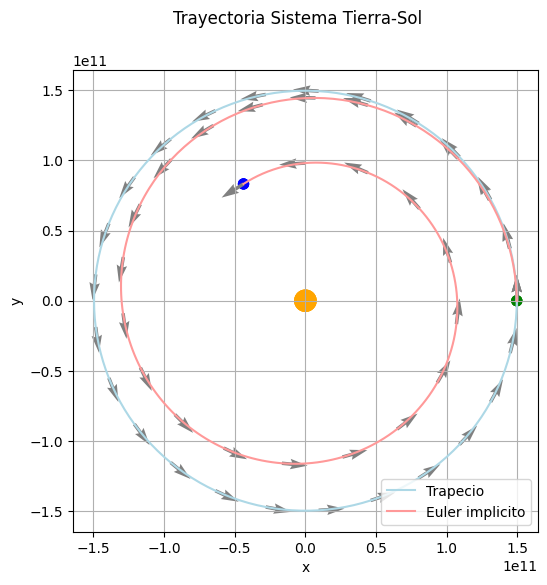

In [ ]:
N=300
h = (t_final-t0)/N
tm, r_real = trapecio_impl_sistema(m,t0,y0,f,df,h,N)
tm, r_fail = backward_euler_sistemas(m,t0,y0,f,df,h,N)

fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(True)

startangle = np.pi/4
ballradius = 4E9
ballradius2 = 8E9

moon = plt.Circle((np.cos(startangle), np.sin(startangle)), ballradius, fc='green', figure=fig)
moon2 = plt.Circle((np.cos(startangle), np.sin(startangle)), ballradius, fc='blue', figure=fig)
Earth = plt.Circle((np.cos(startangle), np.sin(startangle)), ballradius2, fc='orange', figure=fig)


nframes = len(r_real[0])  # El número de fotogramas es igual al número de puntos en la trayectoria
milisec = 50

hist_x1 = []
hist_y1 = []
hist_x2 = []
hist_y2 = []
path, = ax.plot(hist_x1, hist_y1, figure=fig, label="Trapecio" ,color='lightblue')
path2, = ax.plot(hist_x2, hist_y2, figure=fig,  label="Euler implicito" , color='#FF9999')

x = r_real[0, 0]
y = r_real[1, 0]

hist_x1.append(x)
hist_y1.append(y)

x2 = r_fail[0, 0]
y2 = r_fail[1, 0]

hist_x2.append(x2)
hist_y2.append(y2)

bound = r_real[0,0]+(r_real[0,0]/10)

def init():
    ax.set_xlim(-bound, bound)
    ax.set_ylim(-bound, bound)
    ax.add_artist(moon)
    ax.add_artist(moon2)
    ax.add_artist(Earth)
    return moon,moon2,Earth,path,path2,

def animate(i):
    x = r_real[0, i]
    y = r_real[1, i]
    moon.center = (x, y)
    hist_x1.append(x)
    hist_y1.append(y)
    path.set_data(hist_x1[:], hist_y1[:])

    x2 = r_fail[0, i]
    y2 = r_fail[1, i]
    moon2.center = (x2, y2)
    hist_x2.append(x2)
    hist_y2.append(y2)
    path2.set_data(hist_x2[:], hist_y2[:])

    # Dibuja los vectores de velocidad
    if i % 12 == 0:  # Dibuja solo algunos vectores para evitar solapamiento
        vx = r_real[2, i] / 1E3
        vy = r_real[3, i] / 1E3
        ax.quiver(x, y, vx, vy, color='grey')
        vx_2 = r_fail[2, i] / 1E3
        vy_2 = r_fail[3, i] / 1E3
        ax.quiver(x2, y2, vx_2, vy_2, color='grey')

    return moon,moon2, path,path2

ax.set_xlabel("x")
ax.set_ylabel("y")
plt.suptitle("Trayectoria Sistema Tierra-Sol")
plt.legend()
animation = FuncAnimation(fig, animate, init_func=init, frames=nframes, interval=80, blit=True)
animation.save('ballpath.gif')

plt.show()


### Sistema Uranus-Sol

In [ ]:
#condiciones iniciales PVI
t0_u = 0
r_u=2867.043E9  #m   distancia  Sol-Urano
y0_u = np.array([r_u,0,0,np.sqrt(C/r_u)])  #[x0,y0,vx0,vy0]


#Condiciones de parada
t_final_u=np.sqrt(4*r_u/C)*(np.pi*r_u)

print(" Condiciones iniciales \n x0={} m, y0={}, Vx0={}, Vy0={:.2f} m/s".format(y0_u[0],y0_u[1],y0_u[2],y0_u[3]))
print(" tiempo  final calculado  para este sistema t_final={}".format(t_final_u))

 Condiciones iniciales 
 x0=2867043000000.0 m, y0=0.0, Vx0=0.0, Vy0=6806.32 m/s
 tiempo  final calculado  para este sistema t_final=2646682087.736424


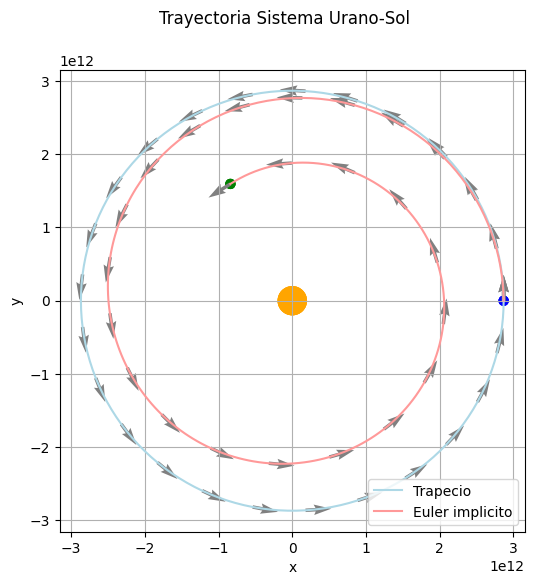

In [ ]:
N_u=300
h_u = (t_final_u-t0_u)/N_u
tm, r_real_u = trapecio_impl_sistema(m,t0_u,y0_u,f,df,h_u,N_u)
tm, r_fail_u = backward_euler_sistemas(m,t0_u,y0_u,f,df,h_u,N_u)

fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(True)

startangle = np.pi/4
ballradius = 7E10
ballradius2 = 2E11

moon = plt.Circle((np.cos(startangle), np.sin(startangle)), ballradius, fc='blue', figure=fig)
moon2 = plt.Circle((np.cos(startangle), np.sin(startangle)), ballradius, fc='green', figure=fig)
Earth = plt.Circle((np.cos(startangle), np.sin(startangle)), ballradius2, fc='orange', figure=fig)


nframes = len(r_real_u[0])  # El número de fotogramas es igual al número de puntos en la trayectoria
milisec = 50

hist_x1 = []
hist_y1 = []
hist_x2 = []
hist_y2 = []
path, = ax.plot(hist_x1, hist_y1, figure=fig, label="Trapecio" ,color='lightblue')
path2, = ax.plot(hist_x2, hist_y2, figure=fig,  label="Euler implicito" , color='#FF9999')

x = r_real_u[0, 0]
y = r_real_u[1, 0]

hist_x1.append(x)
hist_y1.append(y)

x2 = r_fail_u[0, 0]
y2 = r_fail_u[1, 0]

hist_x2.append(x2)
hist_y2.append(y2)

bound = r_real_u[0,0]+(r_real_u[0,0]/10)

def init():
    ax.set_xlim(-bound, bound)
    ax.set_ylim(-bound, bound)
    ax.add_artist(moon)
    ax.add_artist(moon2)
    ax.add_artist(Earth)
    return moon,moon2,Earth,path,path2,

def animate(i):
    x = r_real_u[0, i]
    y = r_real_u[1, i]
    moon.center = (x, y)
    hist_x1.append(x)
    hist_y1.append(y)
    path.set_data(hist_x1[:], hist_y1[:])

    x2 = r_fail_u[0, i]
    y2 = r_fail_u[1, i]
    moon2.center = (x2, y2)
    hist_x2.append(x2)
    hist_y2.append(y2)
    path2.set_data(hist_x2[:], hist_y2[:])

    # Dibuja los vectores de velocidad
    if i % 12 == 0:  # Dibuja solo algunos vectores para evitar solapamiento
        vx = r_real_u[2, i] / 1E3
        vy = r_real_u[3, i] / 1E3
        ax.quiver(x, y, vx, vy, color='grey')
        vx_2 = r_fail_u[2, i] / 1E3
        vy_2 = r_fail_u[3, i] / 1E3
        ax.quiver(x2, y2, vx_2, vy_2, color='grey')

    return moon,moon2, path,path2

ax.set_xlabel("x")
ax.set_ylabel("y")
plt.suptitle("Trayectoria Sistema Urano-Sol")
plt.legend()
animation = FuncAnimation(fig, animate, init_func=init, frames=nframes, interval=80, blit=True)
animation.save('ballpath2.gif')

plt.show()


### Comparación trayectoria  Tierra  Urano

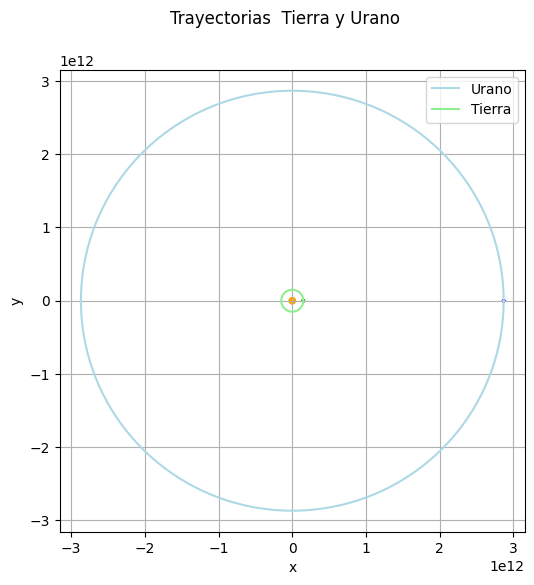

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(True)

startangle = np.pi/4
ballradius = 0.25E11
ballradius2 = 0.25E11
ballradius3 = 0.5E11

moon = plt.Circle((np.cos(startangle), np.sin(startangle)), ballradius, fc='blue', figure=fig)
moon2 = plt.Circle((np.cos(startangle), np.sin(startangle)), ballradius2, fc='green', figure=fig)
Earth = plt.Circle((np.cos(startangle), np.sin(startangle)), ballradius3, fc='orange', figure=fig)


nframes = len(r_real_u[0])  # El número de fotogramas es igual al número de puntos en la trayectoria
milisec = 50

hist_x1 = []
hist_y1 = []
hist_x2 = []
hist_y2 = []
path, = ax.plot(hist_x1, hist_y1, figure=fig, label="Urano" ,color='lightblue')
path2, = ax.plot(hist_x2, hist_y2, figure=fig,  label="Tierra" , color='lightgreen')

x = r_real_u[0, 0]
y = r_real_u[1, 0]

hist_x1.append(x)
hist_y1.append(y)

x2 = r_real[0, 0]
y2 = r_real[1, 0]

hist_x2.append(x2)
hist_y2.append(y2)

bound = r_real_u[0,0]+(r_real_u[0,0]/10)

def init():
    ax.set_xlim(-bound, bound)
    ax.set_ylim(-bound, bound)
    ax.add_artist(moon)
    ax.add_artist(moon2)
    ax.add_artist(Earth)
    return moon,moon2,Earth,path,path2,

def animate(i):
    x = r_real_u[0, i]
    y = r_real_u[1, i]
    moon.center = (x, y)
    hist_x1.append(x)
    hist_y1.append(y)
    path.set_data(hist_x1[:], hist_y1[:])

    x2 = r_real[0, i]
    y2 = r_real[1, i]
    moon2.center = (x2, y2)
    hist_x2.append(x2)
    hist_y2.append(y2)
    path2.set_data(hist_x2[:], hist_y2[:])

    return moon,moon2, path,path2

ax.set_xlabel("x")
ax.set_ylabel("y")
plt.suptitle("Trayectorias  Tierra y Urano")
plt.legend()
animation = FuncAnimation(fig, animate, init_func=init, frames=nframes, interval=80, blit=True)
animation.save('ballpath3.gif')

plt.show()


## Problema de 2 cuerpos  masas  comparables
 Tenemos dos cuerpos de masas comparables $m_1$ y $m_2$ bajo la accion mutua gravitatoria.

 $$f_{12}=-\frac{Gm_1m_2}{|r|^2}\hat{r}$$
con $r$ el vector posición

$r=r_1-r_2$ centrado en el origen
$r=(x_1-x_2)\hat{i}+(y_1-y_2)\hat{j}$



 Planteando los  diagramas de cuerpo libre sobre  la masa  1 tenemos que la aceleración de este es

$$a_1=\left\{\begin{array}{c}
\ddot{x_1}=-\frac{Gm_2}{((x_1-x_2)^2+(y_1-y_2)^2)^\frac{3}{2}}(x_1-x_2)\hat{i}\\
\ddot{y_1}=-\frac{Gm_2}{((x_1-x_2)^2+(y_1-y_2)^2)^\frac{3}{2}}(y_1-y_2)\hat{j}
\end{array} \right.$$

 veamos  ahora que este  munto esta planteado  con elsistma deejes coordenados  fueradelcentro de masa, y dado que este no se mueve, podemos  ubicarlo  justo alli, para eso  concideremos las coordenadas del centro de masa

$$X_{cm}=\frac{m_1x_1+m_2x_2}{m_1+m_2}$$
$$Y_{cm}=\frac{m_1y_1+m_2y_2}{m_1+m_2}$$

Si queremos que estas sean cero podemos encontrar la relación entre las coordenadas  de ambas  masas $$x_1=-\frac{m_2}{m_1}x_2;y_1=-\frac{m_2}{m_1}y_2 $$ asi que   basta  con solucionar el conjunto de ecuaciones para un cuerpo  con  $r$ de la forma
 $$ r=\frac{m_1+m_2}{m_2}(x_1\hat{i}+y_1\hat{j})$$  cuya norma es
  $$ |r|=\frac{m_1+m_2}{m_2}(x_1^2+y_1^2)^{1/2}$$
 generalizando  el sistema

  $$ \dot{x}= V_x$$
  $$ \dot{y}= V_y$$
  $$ \dot{V_x}= -\frac{G(m_2^3)x_1}{(m_1+m_2)^2(x_1^2+y_1^2)^{3/2}}$$
  $$ \dot{V_y}= -\frac{G(m_2^3)y_1}{(m_1+m_2)^2(x_1^2+y_1^2)^{3/2}}$$

y al final se hace una correción para  las coordenadas para la  masa 2
   $$r_2=-\frac{m_1}{m_2}r_1$$
   

In [7]:
G=4*(np.pi**2)  #UA^3 *Ms^-1*(Año sideral)^-2
#m1=2.2   #Ms   masas solares   Siruis A
#m2=0.98  #1.018   #Ms   masas solares   Siruis B
m1=0.907   #Ms   masas solares   alpha centaury B
m2=1.1     #Ms   masas solares   alpha centaury A

M=m1+m2
C=G*M
K=-G*(m2**3)/(M**2)

print("Los valores a las  constantes  son  G={} m^3/ kg s^2,masa 1 ={} M solares , masa 2={} M solares".format(G,m1,m2))


def sistema_problema_2bcuerpo(t,r):
  """
  Esta  función calcula los  valores de la  aceleración  en cada componente,
   representa el sistema de EDO's dado para el problema de  un  cuerpo.
  ENTRADAS
    r[array] : el array de valores que representan las coordenadas x, y, vx,vy en un tiempo t
  SALIDAS
    a[array] : array  de valores  que representan la aceleración y velocidades  en el plano en un tiempo t
  """
  x,y,vx,vy=r
  norm_r=np.sqrt((x**2)+(y**2))

  dx=vx
  dy=vy
  dVx=(K*x)/(norm_r**3)
  dVy=(K*y)/(norm_r**3)

  return np.array([dx,dy,dVx,dVy])

def jacobiano_sistema_2bcuerpo(t,r):
  """
  Esta  función calcula el jacobiano del sistema de ecuaciones dado para el problema de  un  cuerpo.
  ENTRADAS
    r[array] : array  de valores que representan las coordenadas x,y,vx,vy en un tiempo t
  SALIDAS
    J[array] : Matriz de valores  que representan el jacobiano del sistema de EDO's
  """
  x,y,vx,vy=r
  norm_r2=(x**2)+(y**2)

  dfxx=0
  dfxy=0
  dfxvx=1
  dfxvy=0

  dfyx=0
  dfyy=0
  dfyvx=0
  dfyvy=1

  dfvxx=K*(norm_r2**(3/2)-((x**2)*3*np.sqrt(norm_r2)))/(norm_r2**3)
  dfvxy=-K*x*3*y*(norm_r2**(-5/2))
  dfvxvx=0
  dfvxvy=0

  dfvyx=-K*y*3*x*(norm_r2**(-5/2))
  dfvyy=K*(norm_r2**(3/2)-((y**2)*3*np.sqrt(norm_r2)))/(norm_r2**3)
  dfvyvx=0
  dfvyvy=0



  return np.array([[dfxx, dfxy,dfxvx,dfxvy],[dfyx, dfyy,dfyvx,dfyvy],[dfvxx,dfvxy,dfvxvx,dfvxvy],[dfvyx,dfvyy,dfvyvx,dfvyvy]])

Los valores a las  constantes  son  G=39.47841760435743 m^3/ kg s^2,masa 1 =0.907 M solares , masa 2=1.1 M solares


la velocidad inicial es de 6=UA/año sideral

 tiempo final=80 Año sideral 

 El tamaño del paso  es h=0.08  con N=1000 número de iteraciones 



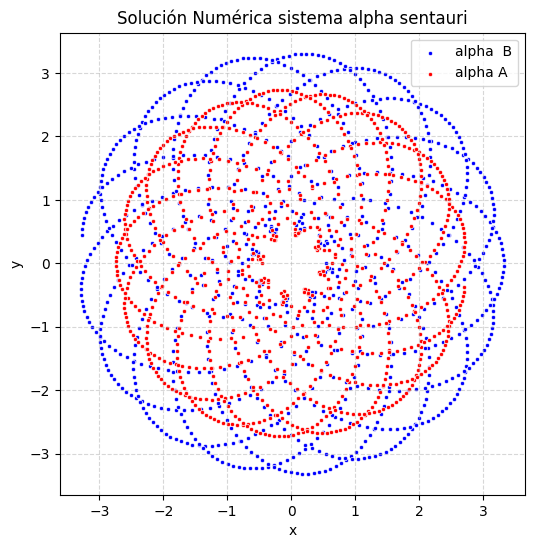

In [8]:
#condiciones iniciales PVI
t0 = 0

#r=149.598E9  #m   distancia  Sol-TIerra
d=1  #23.7 #UA
r=m2*d/M
v0=6 #np.sqrt((G*m1)/r)
y0 = np.array([r,0,0,v0])  #[x1_0,y1_0,x2_0,y2_0,Vx1_0,Vy1_0,Vx2_0,Vy2_0]

print("la velocidad inicial es de {}=UA/año sideral".format(v0))

#Condiciones de parada
t_final=80
#t_final=np.sqrt(r/(G*M))*(2*np.pi*r)
N = int(1000)     #Número de iteraciones


print("\n tiempo final={} Año sideral ".format(t_final))

#parametros de implementación numérica
m = 4                 #número de variables
h = (t_final-t0)/N     # tamaño del paso
f=sistema_problema_2bcuerpo
df=jacobiano_sistema_2bcuerpo

print("\n El tamaño del paso  es h={}  con N={} número de iteraciones \n".format(h,N))

#aproximación de la solución
tm, r_masa1 = trapecio_impl_sistema(m,t0,y0,f,df,h,N)

r_masa2=-(m1/m2)*r_masa1[:,:]

#Grafica de los resultados  en 2D
plt.figure(figsize=(6, 6))
sns.scatterplot(x=r_masa1[0,:], y=r_masa1[1,:], label='alpha  B', color='blue', marker ='.')
sns.scatterplot(x=r_masa2[0,:], y=r_masa2[1,:], label='alpha A', color='red', marker ='.')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solución Numérica sistema alpha sentauri')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


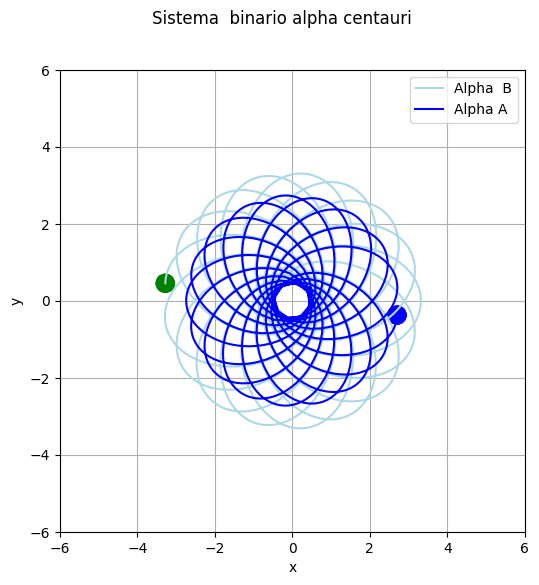

In [9]:

fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(True)

startangle = np.pi/4
ballradius = 0.25


moon = plt.Circle((np.cos(startangle), np.sin(startangle)), ballradius, fc='green', figure=fig)
moon2 = plt.Circle((np.cos(startangle), np.sin(startangle)), ballradius, fc='blue', figure=fig)

nframes = len(r_masa1[0])  # El número de fotogramas es igual al número de puntos en la trayectoria
milisec = 50

hist_x1 = []
hist_y1 = []
hist_x2 = []
hist_y2 = []
path, = ax.plot(hist_x1, hist_y1, figure=fig, label="Alpha  B" ,color='lightblue')
path2, = ax.plot(hist_x2, hist_y2, figure=fig, label="Alpha A" ,color='blue')
x = r_masa1[0, 0]
y = r_masa1[1, 0]

hist_x1.append(x)
hist_y1.append(y)

x2 = r_masa2[0, 0]
y2 = r_masa2[1, 0]

hist_x2.append(x2)
hist_y2.append(y2)

bound = np.max(abs(r_masa1[:]))

def init():
    ax.set_xlim(-bound, bound)
    ax.set_ylim(-bound, bound)
    ax.add_artist(moon)
    ax.add_artist(moon2)

    return moon,moon2,path,path2,

def animate(i):
    x = r_masa1[0, i]
    y = r_masa1[1, i]
    moon.center = (x, y)
    hist_x1.append(x)
    hist_y1.append(y)
    path.set_data(hist_x1[:], hist_y1[:])

    x2 = r_masa2[0, i]
    y2 = r_masa2[1, i]
    moon2.center = (x2, y2)
    hist_x2.append(x2)
    hist_y2.append(y2)
    path2.set_data(hist_x2[:], hist_y2[:])


    return moon,moon2, path,path2

ax.set_xlabel("x")
ax.set_ylabel("y")
plt.suptitle("Sistema  binario alpha centauri ")
plt.legend()
animation = FuncAnimation(fig, animate, init_func=init, frames=nframes, interval=80, blit=True)
animation.save('ballpath4.gif')

plt.show()

## Problema de 1 cuerpo, masa  variable

 Un cuerpo de masa $m_1$  bajo la acción gravitatoria de un  cuerpo de masa $M$,  con $M>>m$
 $$\frac{dp}{dt}=\frac{d(mv)}{dt}=\dot{m}v+ma=F$$

 Para este problema  consideramos  $m$   variable en  función del tiempo $m(t)$   con  perdida de masa  cuya  variación es $\dot{m}=\alpha m^2$  asi  la  aceleración queda

 $$a=-\frac{GM}{|r|^2}\hat{r}-(\alpha m)\dot{r}$$
con $r$ el vector posición $r=x\hat{i}+y\hat{j}$
asi  la aceleración por componentes es

$$a=\left\{\begin{array}{c}
\ddot{x}=-\frac{GM}{(x^2+y^2)^\frac{3}{2}}x\hat-(\alpha m)V_x\\
\ddot{y}=-\frac{GM}{(x^2+y^2)^\frac{3}{2}}y\hat-(\alpha m)V_y
\end{array} \right.$$

Pero los  metodos  conocidos  para implementar en este proyecto  son  para  EDO's  de primer  orden  asi  que  reescribiremos el sistema, sabiendo que la  velocidad $V$ es la primera derivada de la posición, por lo tanto  el sistema  queda  de la  siguiente manera

$$\left\{\begin{array}{c}
\dot{x}=V_x\\
\dot{y}=V_y\\
\dot{V}_x=-\frac{GM}{(x^2+y^2)^\frac{3}{2}}x-(\alpha m)V_x\\
\dot{V}_y=-\frac{GM}{(x^2+y^2)^\frac{3}{2}}y-(\alpha m)V_y\\
\dot{m}=\alpha m^2
\end{array} \right.$$

Si $\alpha<0$ es perdida de masa en el tiempo, si $\alpha>0$ es ganancia de masa
 y si $\alpha=0$ la masa es constante

In [ ]:
G=4*(np.pi**2)  #UA^3 *Ms^-1*(Año sideral)^-2
M=1   #Ms   masas solares
alpha=-1E5  #  si es negativo  pierde masa  si es positivo gana masa

C=G*M

print("Los valores a las  constantes  son  G={} UA^3 *Ms^-1*(Año sideral)^-2, Masa mayor  ={} Ms, alpha={}".format(G,M,alpha))


def sistema_problema_1cuerpo_mv(t,r):
  """
  Esta  función calcula los  valores de la  aceleración  en cada componente,
   representa el sistema de EDO's dado para el problema de  un  cuerpo.
  ENTRADAS
    r[array] : el array de valores que representan las coordenadas x, y, vx,vy en un tiempo t
  SALIDAS
    a[array] : array  de valores  que representan la aceleración y velocidades  en el plano en un tiempo t
  """
  x,y,vx,vy,m=r
  norm_r=np.sqrt((x**2)+(y**2))

  dx=vx
  dy=vy
  dVx=-(C*x)/(norm_r**3)-alpha*m*vx
  dVy=-(C*y)/(norm_r**3)-alpha*m*vx
  dm=alpha*(m**2)

  return np.array([dx,dy,dVx,dVy,dm])

def jacobiano_sistema_1cuerpo_mv(t,r):
  """
  Esta  función calcula el jacobiano del sistema de ecuaciones dado para el problema de  un  cuerpo.
  ENTRADAS
    r[array] : array  de valores que representan las coordenadas x,y,vx,vy en un tiempo t
  SALIDAS
    J[array] : Matriz de valores  que representan el jacobiano del sistema de EDO's
  """
  x,y,vx,vy,m=r
  norm_r2=(x**2)+(y**2)

  dfxx=0
  dfxy=0
  dfxvx=1
  dfxvy=0
  dfxm=0

  dfyx=0
  dfyy=0
  dfyvx=0
  dfyvy=1
  dfym=0

  dfvxx=-C*(norm_r2**(3/2)-((x**2)*3*np.sqrt(norm_r2)))/(norm_r2**3)
  dfvxy=C*x*3*y*(norm_r2**(-5/2))
  dfvxvx=-alpha*m
  dfvxvy=0
  dfvxm=-alpha*vx

  dfvyx=C*y*3*x*(norm_r2**(-5/2))
  dfvyy=-C*(norm_r2**(3/2)-((y**2)*3*np.sqrt(norm_r2)))/(norm_r2**3)
  dfvyvx=0
  dfvyvy=-alpha*m
  dfvym=-alpha*vy

  dfmx=0
  dfmy=0
  dfmvx=0
  dfmvy=0
  dfmm=2*alpha*m



  return np.array([[dfxx, dfxy,dfxvx,dfxvy,dfxm],[dfyx, dfyy,dfyvx,dfyvy,dfym],[dfvxx,dfvxy,dfvxvx,dfvxvy,dfvxm],[dfvyx,dfvyy,dfvyvx,dfvyvy,dfvym],[dfmx,dfmy,dfmvx,dfmvy,dfmm]])

Los valores a las  constantes  son  G=39.47841760435743 UA^3 *Ms^-1*(Año sideral)^-2, Masa mayor  =1 Ms, alpha=-100000.0



 tiempo final=20 año sideral 

 El tamaño del paso  es h=0.02  con N=1000 número de iteraciones 



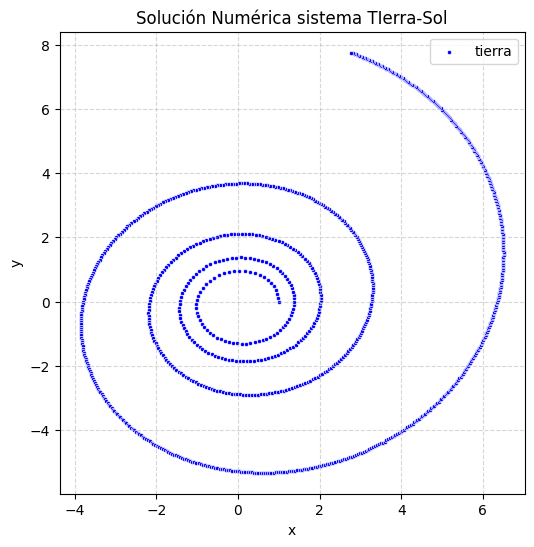

In [ ]:
#condiciones iniciales PVI
t0 = 0
#Mm=5.9722E24   #kg  masa de la tierra
#r=149.598E9  #m   distancia  Sol-TIerra
r=1  #UA
m0=3E-6  #Ms
y0 = np.array([r,0,0,np.sqrt(C/r),m0])


#Condiciones de parada
#t_final=50
t_final=20
N = int(1000)     #Número de iteraciones


print("\n tiempo final={} año sideral ".format(t_final))

#parametros de implementación numérica
m = 5                 #número de variables
h = (t_final-t0)/N     # tamaño del paso
f=sistema_problema_1cuerpo_mv
df=jacobiano_sistema_1cuerpo_mv

print("\n El tamaño del paso  es h={}  con N={} número de iteraciones \n".format(h,N))

#aproximación de la solución
tm, r_sol = trapecio_impl_sistema(m,t0,y0,f,df,h,N)

#Grafica de los resultados  en 2D
plt.figure(figsize=(6, 6))
sns.scatterplot(x=r_sol[0,:], y=r_sol[1,:], label='tierra', color='blue', marker ='.')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solución Numérica sistema TIerra-Sol')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


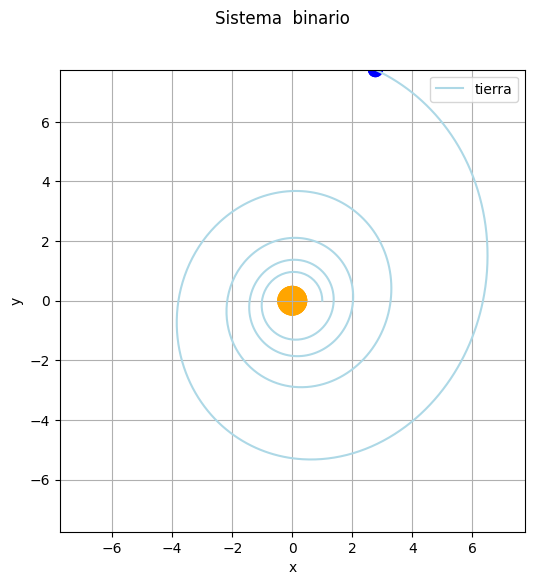

In [ ]:

fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(True)

startangle = np.pi/4
ballradius = 0.25
ballradius2= 0.5


moon = plt.Circle((np.cos(startangle), np.sin(startangle)), ballradius, fc='blue', figure=fig)
Earth = plt.Circle((np.cos(startangle), np.sin(startangle)), ballradius2, fc='orange', figure=fig)

nframes = len(r_sol[0])  # El número de fotogramas es igual al número de puntos en la trayectoria
milisec = 50

hist_x1 = []
hist_y1 = []

path, = ax.plot(hist_x1, hist_y1, figure=fig, label="tierra" ,color='lightblue')

x = r_sol[0, 0]
y = r_sol[1, 0]

hist_x1.append(x)
hist_y1.append(y)


bound = np.max(abs(r_sol))
def init():
    ax.set_xlim(-bound, bound)
    ax.set_ylim(-bound, bound)
    ax.add_artist(moon)
    ax.add_artist(Earth)

    return Earth,moon2,path

def animate(i):
    x = r_sol[0, i]
    y = r_sol[1, i]
    moon.center = (x, y)
    Earth.center = (0, 0)
    hist_x1.append(x)
    hist_y1.append(y)
    path.set_data(hist_x1[:], hist_y1[:])


    return moon, path, Earth

ax.set_xlabel("x")
ax.set_ylabel("y")
plt.suptitle("Sistema  tierra-sol, masa variable  ")
plt.legend()
animation = FuncAnimation(fig, animate, init_func=init, frames=nframes, interval=80, blit=True)
animation.save('ballpath5.gif')

plt.show()

#Referencias

*   [1]Newtonian constant of gravitation. Nist.gov. Recuperado el 28 de marzo de 2024, de https://physics.nist.gov/cgi-bin/cuu/Value?bg|search_for=gravitational


*   [2]Earth fact sheet. Nasa.gov. Recuperado el 28 de marzo de 2024, de https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html

*   [3] Moon fact sheet. Nasa.gov. Recuperado el 28 de marzo de 2024, de https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html

*   [4]Walker, J., & Resnick, R. (2004). Fundamentals of physics: Chapters 1-21 v. 1 (7a ed.). John Wiley & Sons. Chapter 13, pg.349.

* [5] Sun fact sheet. Nasa.gov. Recuperado el 30 de abril de 2024, de  https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html

* [6]NASA. (2011, noviembre 2). Measuring a white dwarf star. NASA https://www.nasa.gov/image-article/measuring-white-dwarf-star/#:~:text=Based%20on%20the%20Hubble%20measurements,miles%20(2.4%20million%20kilometers).

* [7]Wikipedia contributors. (s/f). Alfa Centauri. Wikipedia, The Free Encyclopedia. https://es.wikipedia.org/w/index.php?title=Alfa_Centauri&oldid=159615352




